In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress annoying warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries Loaded Successfully! ✅")

SyntaxError: invalid syntax (939881390.py, line 2)

In [2]:
pip install pandas numpy matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [4]:
# specific file name
file_name = 'final_merged_data.csv'

# Check multiple common locations
possible_paths = [
    f"data/{file_name}",            # If notebook is in project root
    f"notebook/data/{file_name}",   # If running from VS Code root
    file_name                       # If notebook is inside the data folder
]

df = None
for path in possible_paths:
    if os.path.exists(path):
        print(f"📂 Found data at: {path}")
        df = pd.read_csv(path)
        break

if df is None:
    print("❌ Error: File not found. Please check your 'notebook/data' folder.")
else:
    # Convert Date column immediately
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"✅ Data Loaded. Shape: {df.shape}")
    display(df.head(3))

NameError: name 'os' is not defined

In [18]:
# Cell 3: Smart Data Cleaning (Fixed)

# 1. Drop columns that are 100% Empty (The "Zombie" columns like Temperature_x)
# how='all' means "Only drop if EVERYTHING is missing"
df_clean = df.dropna(axis=1, how='all').copy()

print(f"🧹 Removed {len(df.columns) - len(df_clean.columns)} empty columns.")

# 2. Explicitly PROTECT our Targets
# Even if PM10 has gaps, we MUST keep it.
targets = ['PM10', 'NO2', 'CO', 'O3', 'SO2']

# 3. Fill small gaps (Interpolation)
# This fills the 15% missing data in PM10 using the average of neighbors
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
df_clean[numeric_cols] = df_clean[numeric_cols].interpolate(method='linear', limit_direction='both')

# 4. Verification
if 'PM10' in df_clean.columns:
    print("✅ PM10 is safe and ready!")
else:
    print("❌ CRITICAL: PM10 is still missing. Check the source CSV.")

🧹 Removed 18 empty columns.
✅ PM10 is safe and ready!


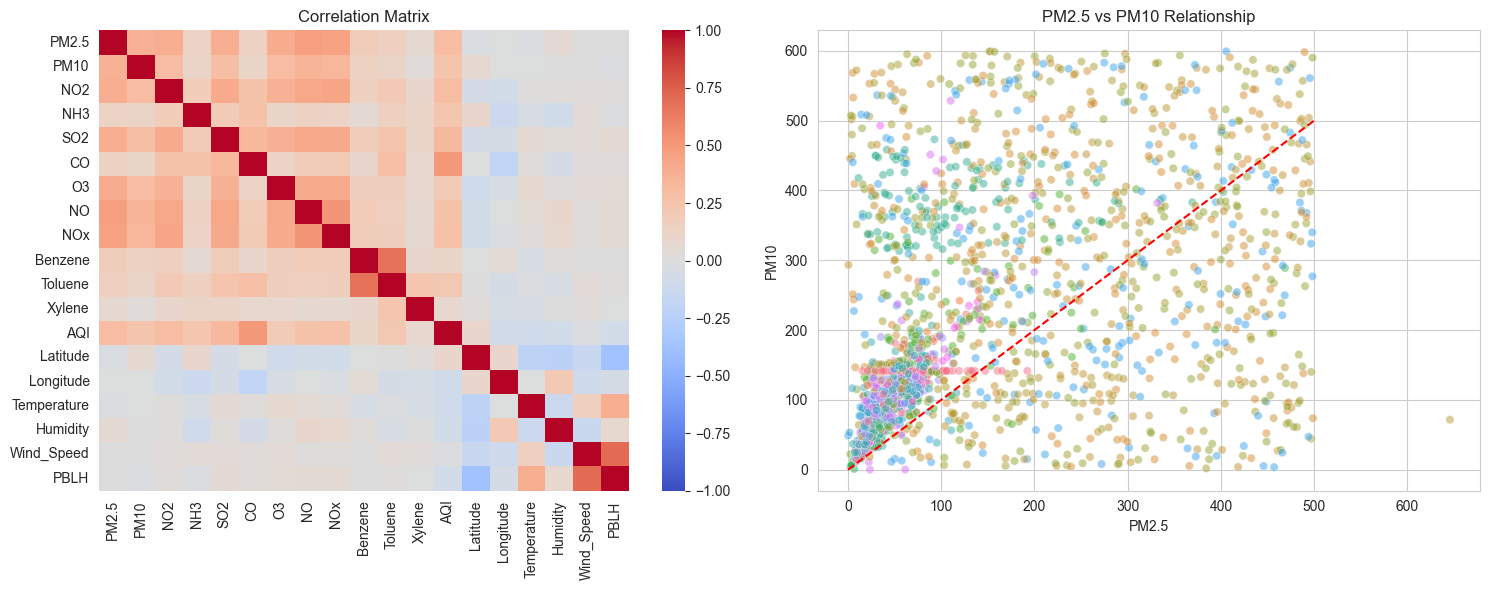

In [19]:
# Cell 4: The "Virtual Sensor" Proof (Safe Plotting)

import numpy as np

# 1. Double check that PM10 exists
if 'PM10' not in df_clean.columns:
    print("❌ Error: PM10 column is missing. Please re-run Cell 3.")
else:
    # 2. Filter data specifically for the plot
    plot_data = df_clean.dropna(subset=['PM2.5', 'PM10']).copy()
    
    plt.figure(figsize=(15, 6))

    # Subplot 1: Correlation Heatmap
    plt.subplot(1, 2, 1)
    numeric_df = df_clean.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Matrix")

    # Subplot 2: Linearity Check
    plt.subplot(1, 2, 2)
    
    # Safe Sampling
    if len(plot_data) > 2000:
        sample_data = plot_data.sample(2000, random_state=42)
    else:
        sample_data = plot_data

    sns.scatterplot(data=sample_data, x='PM2.5', y='PM10', alpha=0.5, hue='City', legend=False)
    plt.plot([0, 500], [0, 500], 'r--') # Perfect line
    plt.title("PM2.5 vs PM10 Relationship")

    plt.tight_layout()
    plt.show()

In [20]:
# Cell 5: Complete Feature Engineering

# 1. Temporal Features (Crucial for seasonality)
# The AI needs to know if it's Winter (High Pollution) or Monsoon (Low Pollution)
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Day_of_Week'] = df_clean['Date'].dt.dayofweek  # 0=Monday, 6=Sunday

# 2. Cleanup Column Names (Fixing the "Temperature_x" issue if it exists)
# We prioritize the main weather columns.
rename_map = {
    'Temperature_x': 'Temperature',
    'Humidity_x': 'Humidity',
    'Wind_Speed_x': 'Wind_Speed',
    'pm2_5': 'PM2.5',
    'nitrogen_dioxide': 'NO2'
}
df_clean.rename(columns=rename_map, inplace=True)

# 3. Define the "Virtual Sensor" Architecture
# INPUTS: What your Low-Cost Device will measure physically
inputs = [
    'PM2.5', 'NO2',            # The Physical Sensors (Cheap)
    'Latitude', 'Longitude',   # Location (GPS)
    'Temperature', 'Humidity', 'Wind_Speed', # Weather (API)
    'Month', 'Day_of_Week'     # Time (Calculated)
]

# TARGETS: What the AI will predict (Virtual Sensors)
targets = ['PM10', 'CO', 'SO2', 'O3']

# 4. Verify Feature Existence
# We filter the list to ensure we only ask for columns that actually exist in the dataframe
final_inputs = [col for col in inputs if col in df_clean.columns]
final_targets = [col for col in targets if col in df_clean.columns]

print(f"🚀 Final Inputs: {final_inputs}")
print(f"🎯 Final Targets: {final_targets}")

🚀 Final Inputs: ['PM2.5', 'NO2', 'Latitude', 'Longitude', 'Temperature', 'Humidity', 'Wind_Speed', 'Month', 'Day_of_Week']
🎯 Final Targets: ['PM10', 'CO', 'SO2', 'O3']


In [21]:
# Cell 6: Final Selection & Saving

# 1. Select only the columns we need for the Model
# We keep 'City' and 'Date' just for visualization in the next notebook, 
# but we will drop them before training.
cols_to_keep = final_inputs + final_targets + ['City', 'Date']
df_ai_ready = df_clean[cols_to_keep].copy()

# 2. Final Sanity Check: Drop rows where TARGETS are missing
# We cannot train the AI if the "Teacher" (Target) has no answer key.
df_ai_ready.dropna(subset=final_targets, inplace=True)

# 3. Save to disk
output_path = 'notebook/data/ai_ready_data.csv'
# Ensure the folder exists
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_ai_ready.to_csv(output_path, index=False)

print("="*40)
print(f"✅ SUCCESS: Notebook 1 Complete.")
print(f"📂 AI-Ready Data Saved: {output_path}")
print(f"📊 Final Training Rows: {len(df_ai_ready)}")
print("="*40)

✅ SUCCESS: Notebook 1 Complete.
📂 AI-Ready Data Saved: notebook/data/ai_ready_data.csv
📊 Final Training Rows: 37756
